# Introduction to atomman: Strain class

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction <a id='section1'></a>

This Notebook outlines the Strain class which provides a convenient interface for computing a per-atom strain estimate and related properties.

*New version 1.3.7*: The Strain class has been added that provides a faster, more user-friendly interface for computing the same properties as the older nye_tensor function. 

In [1]:
# Standard Python libraries
import os
import datetime
import time

# http://www.numpy.org/
import numpy as np

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.4.7
Notebook executed on 2022-10-12


## 2. Theory <a id='section2'></a>

The Strain class computes the elastic strain correspondence tensor on a per-atom basis by comparing the local environment around each atom in a current state to the corresponding local environment around the same atom in a reference state.  

### 2.1. Strain correspodence tensor

The algorithm used here follows the one outlined in [Hartley, C. & Mishin, Y. (2005). Acta Materialia 53, 1313-1321.](http://dx.doi.org/10.1016/j.actamat.2004.11.027) and [Hartley, C. S. & Mishin, Y. (2005). Materials Science and Engineering: A 400-401, 18-21.](http://dx.doi.org/10.1016/j.msea.2005.03.076), as well as code obtained from Yuri Mishin. 

The local environment around each atom $\alpha$ is characterized by finding the relative position vectors between atom $\alpha$ and all neighboring atoms within a set cutoff distance of atom $\alpha$. This is done separately for both the reference and current states, leading to two lists of vectors per atom:

- $p_{i \alpha \beta}$ is the neighbor vector between atom $\alpha$ and a neighboring atom $\beta$ in the reference system.
- $q_{i \alpha \gamma}$ is the neighbor vector between atom $\alpha$ and a neighboring atom $\gamma$ in the current system.

For each atom $\alpha$, the sets of neighbors $\beta$ and $\gamma$ are not necessarily the same. Computing the strain correspondence tensor requires that new sets of vectors $P_{i \alpha \delta}$ and $Q_{i \alpha \delta}$ are identified by best matching as many $q_{i \alpha \gamma}$ to a $p_{i \alpha \beta}$ as possible

- For each $q_{i \alpha \gamma}$, find the $p_{i \alpha \beta}$ that is closest to it in angle.  If no $p_{i \alpha \beta}$ is found within $\theta_{max}$ of $q_{i \alpha \gamma}$, then ignore that $q_{i \alpha \gamma}$.
- Check if the best $p_{i \alpha \beta}$ has already been paired with another $q_{i \alpha \gamma}$. If so, compare the lengths of the two $q_{i \alpha \gamma}$ vectors and keep the one closest to the length of $p_{i \alpha \beta}$.

This method means that the number of $\delta$ sets of $P_{i \alpha \delta}$ and $Q_{i \alpha \delta}$ will always be equal to or smaller than $\beta$ and $\gamma$.  

The strain correspondence tensor, $G_{ij \alpha}$, is computed as a least squares solution across all $\delta$ of the linear matrix equation

$$ Q_{i \alpha \delta} G_{ij \alpha} = P_{j \alpha \delta} $$ 


### 2.2. Derived properties

Various strain properties can then be computed using $G_{ij \alpha}$:

- strain tensor

$$ E_{ij \alpha} = \frac{(\delta_{ij} - G_{ij \alpha}) + (\delta_{ij} - G_{ji \alpha})}{2} $$

- strain invariants

$$ I_{1 \alpha} = E_{11 \alpha} + E_{22 \alpha} + E_{33 \alpha} $$
    
$$ I_{2 \alpha} = E_{11 \alpha} E_{22 \alpha} + E_{11 \alpha} E_{33 \alpha} + E_{22 \alpha} E_{33 \alpha} - E_{12 \alpha}^2 - E_{13 \alpha}^2 - E_{23 \alpha}^2 $$
    
$$ I_{3 \alpha} = \det{E_{ij \alpha}} $$
    
- rotation tensor

$$ R_{ij \alpha} = \frac{(\delta_{ij} - G_{ij \alpha}) - (\delta_{ij} - G_{ji \alpha})}{2} $$
 
- angular velocity
 
$$ \omega_{\alpha} = \sqrt{R_{12 \alpha}^2 + R_{13 \alpha}^2 + R_{23 \alpha}^2} $$

### 2.3. Nye tensor

The Nye tensor, $N_{ij \alpha}$, is related to $G_{i j \alpha}$ as

$$ N_{km \alpha} = - \epsilon_{ijk} \partial_i G_{m j \alpha}, $$

where $\epsilon_{ijk}$ is the permutation symbol.

The derivatives of $G_{i j \alpha}$ are obtained numerically by comparing the change in the strain correspondence tensor between each atom $\alpha$ and its neighbors $\gamma$. A single value for each derivative is obtained by least squares fits of the following equations 

$$ G_{i j \gamma} - G_{i j \alpha} = q_{k \alpha \gamma} \partial_k G_{i j \alpha} $$

__Note__ that the equations in the original papers on the atomistic Nye tensor method had a typo with indices. This function has been verified as producing comparable results as the original calculation code used by the authors.    

## 3. Calculation parameter options <a id='section3'></a>

The strain predictions using this algorithm will vary depending on how some of the input parameters are set.


### 3.1. Reference state selection

Ideally, the choice of reference state should correspond to a perfect bulk crystal at zero pressure.  This reference will result in the calculation finding the elastic component of the strain as any plastic effects are ignored due to crystal symmetry translations.  However, identifying the ideal reference state may be challenging for complex systems.  Some possible issues being

- The reference state corresponds to a specific crystal structure.  If the deformation leads to a phase transformation, then the atoms in question will have different strains depending on which reference phase is used for which atom.
- The matching algorithm pairs the current neighbor vectors to the reference ones based on angle.  This assumes that the rotational component of the deformation is small, and may give poor predictions if the orientation of the two systems are not close.
- There is some ambiguity associated with defining the reference state for atoms that are part of a large crystal defect, such as grain and phase boundaries.  The defects themselves can consist of atomic structures, or can be composed of amorphous regions. Thus, specifying the atoms as relative to a bulk crystal state may arguably not be correct.

For these reasons, atomman allows for the reference state to be defined in one of two ways:

- The sets of p vectors can be directly specified for each atom.  This is convenient for simple systems where a single bulk crystal can be used as the reference for all atoms.  Alternatively, an algorithm could be used to determine the optimum crystal and orientation to use on an individual atom basis, then the associated p vectors can be fed in. 
- The p vectors can be determined by supplying a base reference system that represents the current system at an earlier time, i.e. before a defect is inserted and/or deformations are applied. If the base reference system is a bulk single crystal, then this is effectively the same as specifying the individual p vectors for the crystal, but it computes these for you.  Alternatively, for highly complex systems, specifying the base reference system amounts to estimating the elastic strain in the current system relative to the reference system. 

### 3.2. Neighbor cutoff

The cutoff distance used for identifying the p/q vectors does influence the results.  If the cutoff distance is too large, then the calculated strain for a given point will be averaged over a larger region.  This could result in less pronounced strain peaks near defects.  If the cutoff distance is too small, then the number of p/q vectors may be too small to give a good estimate of strain.  From practical experience, a good cutoff seems to be one that encompasses the fewest number of neighbor shells necessary to capture 8 neighbor atoms.  Be sure to place the cutoff roughly halfway between neighbor shells to help keep the number of neighbor atoms close to the same for deformed configurations.  These are practical suggestions and not hard rules, so it is recommended to try a few different cutoffs to see how they affect predictions.

### 3.3. Angle cutoff

The $\theta_{max}$ parameter can also influence the calculated strain properties.  As the p-q matching algorithm is based on angles, the $\theta_{max}$ parameter helps avoid false matches by ignoring q vectors oriented far from any p vectors.  The choice of $\theta_{max}$ has the biggest influence on deformations and defects with large rotational components.   For guidance, the original choice for fcc is 27 degrees, which is close to half of the 60 degree angle between p vectors.


## 4. Strain class <a id='section4'></a>

The Strain class provides a convenient and fast means of computing the various strain properties.  In design, it offers an improvement over the old nye_tensor function in that:

- Constructing p_vectors from a reference system is now built in (rather than calling nye_tensor_p).
- The calculation functions have been rewritten using cython for about a 2x speedup.
- Each strain property is computed only as needed offering for additional speedup when not all properties are needed.

Primary parameters

- __system__ (*atomman.System*) The atomic system to compute the per-atom strain properties and Nye tensor for.
- __neighbors__ (*atomman.NeighborList, optional*) The neighbor list associated with system to use.  Either neighbors or cutoff must be given, or system must have a neighbors attribute.
- __cutoff__ (*float*) Cutoff distance for computing a neighbor list for system.  Either neighbors or cutoff must be given, or system have a neighbors attribute.
- __theta_max__ (*float, optional*) The maximum theta angle in degrees to use when searching for matches between p vectors and q vectors.  Optimum values are dependent on the crystal structure. Default value is 27, which is the original value used for fcc crystals.    
  
Reference state option 1: explicit p vectors

- __p_vectors__ (*array-like object, optional*) List(s) of radial distance vectors between each atom and its nearest neighbors in a perfect crystal setting.  If one list of p_vectors is given, then it is applied to all atoms.
- __axes__ (*array-like object, optional*) 3x3 array of right-handed orthogonal axes to transform the given p vectors.  Only needed if the orientation of the p vectors differs from the system's orientation.

Reference state option 2: reference system
    
- __basesystem__ (*atomman.System, optional*) A reference atomic system to use for constructing the p vectors. 
- __baseneighbors__ (*atomman.NeighborList, optional*) The neighbor list associated with basesystem to use. If basesystem is given, then either baseneighbors or cutoff must be given, or basesystem must have a neighbors attribute.


### 4.1. Load systems

In [2]:
base_system = am.load('atom_dump', 'files/fcc_Al_base.dump')
disl_system = am.load('atom_dump', 'files/fcc_Al_disl.dump')

alat = 4.05

### 4.2. Initialize strain class

In [3]:
# Example #1: Give base and disl systems with a cutoff
strain = am.defect.Strain(disl_system, basesystem=base_system, cutoff=0.9*alat)
strain.p_vectors[0]

array([[0.0, 2.863785756044706, 0.0],
       [-2.4801112157307, 1.4318928780224098, 0.0],
       [2.4801112157308003, -1.4318928780222961, 0.0],
       [2.4801112157308003, 1.4318928780224098, 0.0],
       [1.6534074771537997, 0.0, -2.3382712783200077],
       [-0.8267037385768998, -1.4318928780222961, -2.3382712783200077],
       [-0.8267037385768998, 1.4318928780224098, -2.3382712783200077],
       [0.0, -2.8637857560445923, 0.0],
       [-2.4801112157307, -1.4318928780222961, 0.0],
       [-1.6534074771537999, 0.0, 2.3382712783199935],
       [0.8267037385769003, 1.4318928780224098, 2.3382712783199935],
       [0.8267037385769003, -1.4318928780222961, 2.3382712783199935]],
      dtype=object)

In [4]:
# Example #2: Compute neighbors beforehand, and give p_vectors explicitly

# Compute neighbors for current system
neighbors = disl_system.neighborlist(cutoff=0.9*alat)

# Define p_vectors for fcc cubic (standard reference frame)
p_vectors = alat * np.array([[ 0.5, 0.5, 0.0], [ 0.5, 0.0, 0.5], [ 0.0, 0.5, 0.5],
                             [-0.5, 0.5, 0.0], [-0.5, 0.0, 0.5], [ 0.0,-0.5, 0.5],
                             [ 0.5,-0.5, 0.0], [ 0.5, 0.0,-0.5], [ 0.0, 0.5,-0.5],
                             [-0.5,-0.5, 0.0], [-0.5, 0.0,-0.5], [ 0.0,-0.5,-0.5]])

# Define the transformation axes
xaxis = [-1,-1, 2]
yaxis = [ 1,-1, 0]
zaxis = [ 1, 1, 1]
axes = am.tools.axes_check([xaxis, yaxis, zaxis])

strain = am.defect.Strain(disl_system, neighbors=neighbors, p_vectors=p_vectors, axes=axes)
strain.p_vectors[0]

array([[-1.65340558,  0.        ,  2.33826859],
       [ 0.82670279,  1.43189123,  2.33826859],
       [ 0.82670279, -1.43189123,  2.33826859],
       [ 0.        , -2.86378246,  0.        ],
       [ 2.48010836, -1.43189123,  0.        ],
       [ 2.48010836,  1.43189123,  0.        ],
       [ 0.        ,  2.86378246,  0.        ],
       [-2.48010836,  1.43189123,  0.        ],
       [-2.48010836, -1.43189123,  0.        ],
       [ 1.65340558,  0.        , -2.33826859],
       [-0.82670279, -1.43189123, -2.33826859],
       [-0.82670279,  1.43189123, -2.33826859]])

### 4.3. Class properties

All of the strain-related properties can be retrieved as class attributes.  Each property is computed the first time that it is retrieved and the values are retained.

- __G__ is the strain correspondence tensor for each atom.  As all the other properties depend on this, it will be first computed when any property is called.
- __strain__ is the strain tensor for each atom.
- __invariant1__ is the first strain invariant for each atom.
- __invariant2__ is the second strain invariant for each atom.
- __invariant3__ is the third strain invariant for each atom.
- __rotation__ is the rotation tensor for each atom.
- __angularvelocity__ is the angular velocity for each atom.
- __nye__ is the Nye tensor for each atom.

In [5]:
s = time.time()
G = strain.G
e = time.time()
print('First call for G took', e-s, 'seconds')

s = time.time()
G = strain.G
e = time.time()
print('Second call for G took', e-s, 'seconds')
print(strain.G)

First call for G took 4.234004974365234 seconds
Second call for G took 0.0010006427764892578 seconds
[[[ 9.99998842e-01 -6.52065146e-08 -5.86211323e-08]
  [-1.08196712e-04  9.97999349e-01 -1.94600556e-03]
  [ 8.50971890e-05  2.07595184e-03  1.00097862e+00]]

 [[ 9.99998842e-01 -6.61154254e-08 -6.29769612e-08]
  [-1.05914368e-04  9.97987653e-01 -1.97956797e-03]
  [ 7.95194344e-05  2.03782456e-03  1.00096836e+00]]

 [[ 9.99998842e-01 -6.56904834e-08 -6.07762385e-08]
  [-1.07308439e-04  9.97994580e-01 -1.95945363e-03]
  [ 8.23419310e-05  2.05716840e-03  1.00097375e+00]]

 ...

 [[ 9.99998313e-01  3.20052517e-06 -6.00119553e-07]
  [ 8.99265087e-05  9.98118463e-01  1.91607768e-03]
  [ 6.26711158e-05 -1.81836851e-03  1.00087732e+00]]

 [[ 9.99998918e-01  1.91549000e-07 -7.28492609e-07]
  [ 8.95165793e-05  9.98111963e-01  1.92753409e-03]
  [ 6.18320365e-05 -1.80755118e-03  1.00086855e+00]]

 [[ 9.99998925e-01  1.59876036e-07 -7.21262376e-07]
  [ 8.63555184e-05  9.98108179e-01  1.95376192e-03]

In [6]:
i = 50
print(f'properties for atom {i}:')
print('G =')
print(strain.G[i])
print('strain =')
print(strain.strain[i])
print('invariant1 =', strain.invariant1[i])
print('invariant2 =', strain.invariant2[i])
print('invariant3 =', strain.invariant3[i])
print('rotation =')
print(strain.rotation[i])
print('angularvelocity =', strain.angularvelocity[i])
print('nye =')
print(strain.nye[i])

properties for atom 50:
G =
[[ 9.99998844e-01 -6.69765095e-08 -7.91966162e-08]
 [-9.31157725e-05  9.97950746e-01 -2.11905039e-03]
 [ 5.79882631e-05  1.88665063e-03  1.00091457e+00]]
strain =
[[ 1.15574139e-06  4.65913745e-05 -2.89545333e-05]
 [ 4.65913745e-05  2.04925444e-03  1.16199882e-04]
 [-2.89545333e-05  1.16199882e-04 -9.14566547e-04]]
invariant1 = 0.0011358436297335128
invariant2 = -1.8893796811584699e-06
invariant3 = -2.2279089906352433e-12
rotation =
[[ 0.00000000e+00 -4.65243980e-05  2.90337299e-05]
 [ 4.65243980e-05  0.00000000e+00  2.00285051e-03]
 [-2.90337299e-05 -2.00285051e-03  0.00000000e+00]]
angularvelocity = 0.0020036011663635755
nye =
[[ 2.74911698e-12  3.53218404e-12 -6.31474455e-12]
 [ 6.05014858e-13  3.60961236e-12  2.03567127e-12]
 [-2.03526770e-13 -2.93087484e-12 -1.46707150e-12]]


### 4.4. Save to system

The save_to_system() method will calculate the properties, if needed, and save the values as per-atom properties of the current system.

Parameters

- __properties__ (*str or list, optional*) One or more properties.  If not given, will include strain, invariant1, invariant2, invariant3, angularvelocity and nye.

In [7]:
strain.save_to_system()
print(disl_system.atoms.angularvelocity)

[0.00201216 0.00200979 0.00200945 ... 0.00186799 0.00186834 0.00186185]


### 4.5. asdict

The asdict() method will return the computed properties in the form of a dictionary.  This directly corresponds to the results of calling the old nye_tensor() function except that the property names have changed slightly.

Parameters

- __properties__ (*str or list, optional*) One or more properties.  If not given, will include strain, invariant1, invariant2, invariant3, angularvelocity and nye.

In [8]:
straindict = strain.asdict()
print(straindict.keys())

dict_keys(['strain', 'invariant1', 'invariant2', 'invariant3', 'angularvelocity', 'nye'])


## 5. Plotting <a id='section5'></a>

All of the properties computed with the Strain class are done so on a per-atom basis, but they represent discrete measurements of continuum properties.  The atomman.plot.interpolate_contour() function interpolates the measured discrete per-atom values into a continuum contour plot estimate.  This provides a mapping of the per-atom properties as pseudo-continuum properties.

Basic parameters
    
- **system** (*atomman.System*) The system with the per-atom property that you want to plot.
- **name** (*str*) The name of the per-atom property that you want to plot.
- **property** (*array-like object, optional*) Values for the per-atom property to plot.  If not given, values will be taken as the "name" property of system.
- **index** (*int or tuple, optional*) Specifies which component of a multidimensional property to plot.  Not needed if the property is scalar.
- **magnitude** (*bool, optional*) If True, plots the per-atom magnitude of a vector property.  Cannot be combined with index.  Default value is False.

Plot orientation and range limits

- **plotxaxis** (*str or array-like object, optional*) Indicates the Cartesian direction associated with the system's atomic coordinates to align with the plotting x-axis.  Values are either 3D unit vectors, or strings 'x', 'y', or 'z' for the Cartesian axes directions.  plotxaxis and plotyaxis must be orthogonal.  Default value is 'x' = [1, 0, 0].
- **plotyaxis** (*str or array-like object, optional*) Indicates the Cartesian direction associated with the system's atomic coordinates to align with the plotting y-axis.  Values are either 3D unit vectors, or strings 'x', 'y', or 'z' for the Cartesian axes directions.  plotxaxis and plotyaxis must be orthogonal.  Default value is 'y' = [0, 1, 0].
- **xlim** (*tuple, optional*) The minimum and maximum coordinates along the plotting x-axis to include in the fit.  Values are taken in the specified length_unit.  If not given, then the limits are set based on min and max atomic coordinates along the plotting axis.
- **ylim** (*tuple, optional*) The minimum and maximum coordinates along the plotting y-axis to include in the fit.  Values are taken in the specified length_unit.  If not given, then the limits are set based on min and max atomic coordinates along the plotting axis.
- **zlim** (*tuple, optional*) The minimum and maximum coordinates normal to the plotting axes (i.e. plotxaxis X plotyaxis) to include in the fit.  Values are taken in the specified length_unit.  If not given, then the limits are set based on min and max atomic coordinates along the axis.

Interpolation grid size

- **xbins** (*int, optional*) Specifies the number of interpolation bins to use along the plotting x-axis.  Default value is 200.
- **ybins** (*int, optional*) Specifies the number of interpolation bins to use along the plotting y-axis.  Default value is 200.

Additional options

- **dots** (*bool, optional*) If True, then the positions of the atoms are shown as circles.  Default value is True.
- **czero** (*bool, optional*) If True, the range of property values will be centered around zero, i.e. cmax = -cmin.  If False, cmax and cmin will be independently selected using the property values.  Default value is True.
- **save** (*bool, optional*) If True, the generated plot will be saved to "name.png".  Default value is False.
- **show** (*bool, optional*) If True, matplotlib.pyplot.show() is called.  Default value is True.
- **length_unit** (*str, optional*) The units of length to use for the plotting x- and y-axes.  Default value is 'angstrom'.
- **property_unit** (*str or None, optional*) The units to use for the property value being plotted.  Default value is None, in which no unit conversion is applied.
- **cmap** (*str, optional*) The name of the matplotlib colormap to use.  Default value is 'jet'.
    
Returns

- **intsum** (*float*) The area integrated sum of the property over the plotted region.
- **avsum** (*float*) The average property value taken across all plotting bins.

### 5.1. Plot settings

The plotting function has a large number of parameters that can alter and affect the final plot.  Here, a number of the common values are pulled out and defined separately for clarity.

Notes:

- The interpolation scheme does not do extrapolation, so the plotting range (xlim and ylim) must be inside the range of atomic positions along the two plotting directions.
- zlim controls the position and thickness of the slice of atoms normal to the plotting axes that are included in the interpolation.  The interpolation only considers the 2D positions relative to the plotting axes. If the strain is not invariant to the normal direction, then atoms with the same or similar 2D plotting positions can have different values which will affect the interpolation.  For those cases, the slice should correspond to roughly 1 periodic thickness.

In [9]:
settings = {}
settings['plotxaxis'] = [0,1,0] # Set the plotting x-axis to be aligned with the system's Cartesian y-axis
settings['plotyaxis'] = [0,0,1] # Set the plotting y-axis to be aligned with the system's Cartesian z-axis
settings['xlim'] = (-25, 25)    # Sets the range limits along the plotting x-axis
settings['ylim'] = (-25, 25)    # Sets the range limits along the plotting y-axis
#settings['zlim'] = ()           # Restricts the size of the out-of-plane slice over which atoms are interpolated from. 

### 5.2. Examples

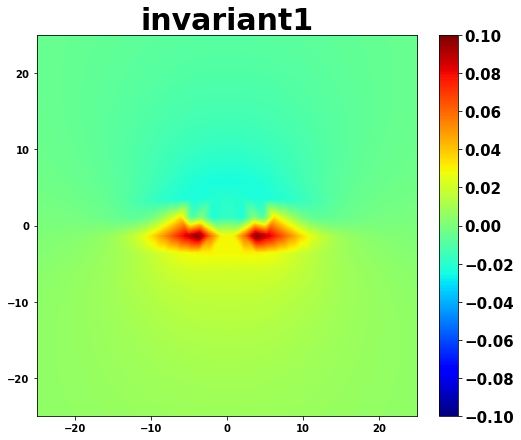

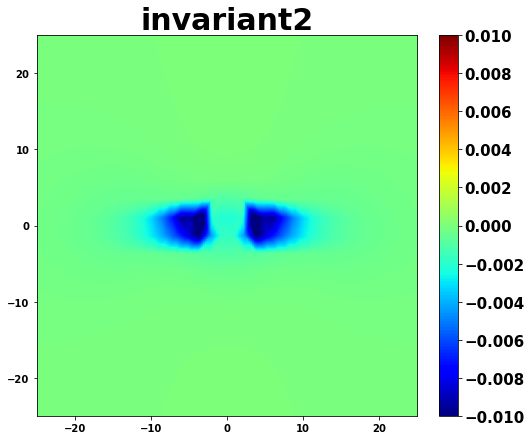

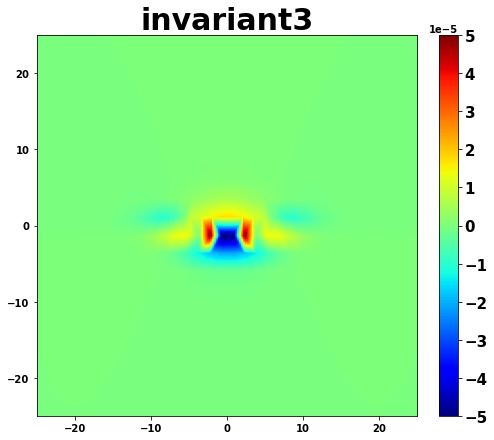

In [10]:
# Make contour plots for the strain invariants
am.plot.interpolate_contour(disl_system, 'invariant1', dots=False, **settings)
am.plot.interpolate_contour(disl_system, 'invariant2', dots=False, **settings)
am.plot.interpolate_contour(disl_system, 'invariant3', dots=False, **settings)
plt.show()

### 5.3. Nye tensor plots

The Nye tensor provides information about the dislocation content within a system.  For a single straight dislocation, the first component of the Nye tensor should correspond to the dislocation's line direction.  The second component then determines if the plots are for the screw component, the edge component, or the slip-plane normal component.

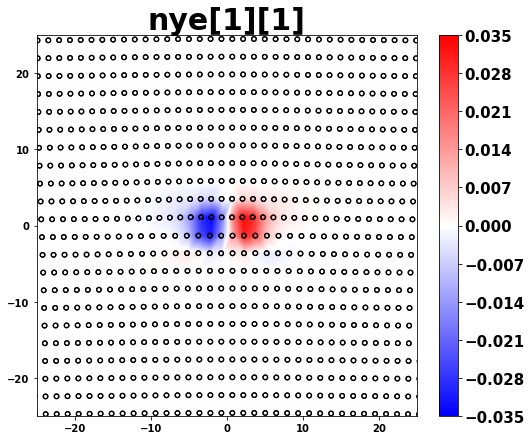

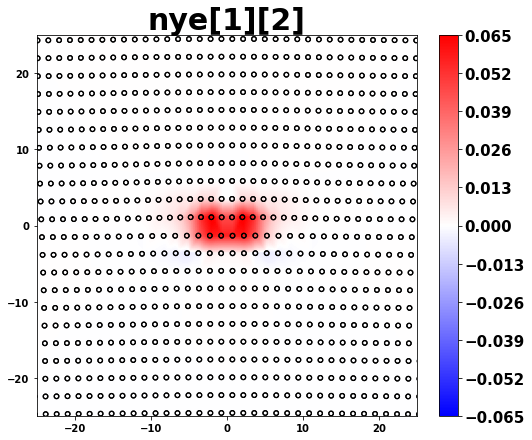

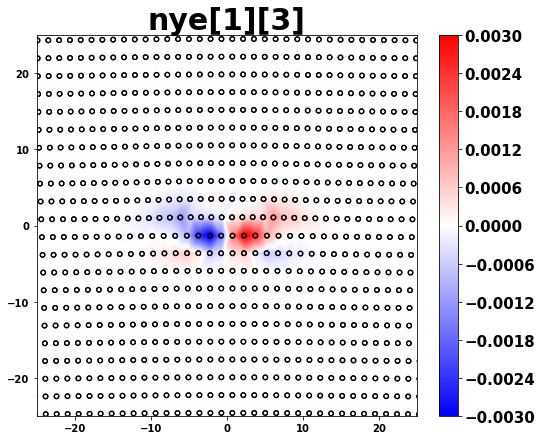

In [11]:
# plot Nye tensor components related to dislocations
intsum = np.empty(3)
intsum[0] = am.plot.interpolate_contour(disl_system, 'nye', prop_index=[0,0], cmap='bwr', **settings)[0]
intsum[1] = am.plot.interpolate_contour(disl_system, 'nye', prop_index=[0,1], cmap='bwr', **settings)[0]
intsum[2] = am.plot.interpolate_contour(disl_system, 'nye', prop_index=[0,2], cmap='bwr', **settings)[0]

The area integrated sum (intsum) for the different Nye tensor plots provides an estimate of the cumulative Burgers vector of dislocations in the plotted region.

In [12]:
burgers = alat * np.array([0.0, 2**0.5/2, 0.0])

print(f'actual Burgers vector:    [{burgers[0]: 7.4f}, {burgers[1]: 7.4f}, {burgers[2]: 7.4f}]')
print(f'estimated Burgers vector: [{intsum[0]: 7.4f}, {intsum[1]: 7.4f}, {intsum[2]: 7.4f}]')

actual Burgers vector:    [ 0.0000,  2.8638,  0.0000]
estimated Burgers vector: [-0.0041,  2.9144,  0.0015]
